### **Decision tree based ML models project description**

We are given a dataset containing various features of the Waze users and 'User Churn' as the target variable. We want to build a Machine Learning model to predict the user churn from this Waze dataset. We will divide the dataset into Train-Validation-Test subsets. We will train the the models Random Forest Classifier and the XGBoost Classifier on the Train dataset. We will compare the performance of these two models on the validation dataset, and choose the champion model. We will find the performance of the champion model on the Test dataset. We will adjust the model parameters to improve performance of the model designed for our specific business need.

**Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)

**Import dataset and review its contents**

In [3]:
df0 = pd.read_csv('waze_dataset.csv')

In [4]:
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
df = df0.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


**Remove the column that contains no useful information**

In [7]:
df = df.drop(['ID'], axis=1)

**Drop the missing values from the dataset**

In [8]:
df.isna().sum()

label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [9]:
df = df.dropna(subset=['label'])

**Construct new suitable features:`km_per_driving_day`, `percent_sessions_in_last_month`, `professional_driver`, `total_sessions_per_day`, `km_per_hour`, `km_per_drive`, `percent_of_drives_to_favorite`. Replace the erroneous infinite values with 0.**

In [10]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df['km_per_driving_day'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.675616e+02
50%      3.241789e+02
75%      7.608293e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [11]:
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

count    14299.000000
mean       581.942399
std       1038.254509
min          0.000000
25%        136.168003
50%        273.301012
75%        558.018761
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [12]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']
df['percent_sessions_in_last_month'].describe()

count    14299.000000
mean         0.449837
std          0.286863
min          0.000000
25%          0.196890
50%          0.424310
75%          0.687251
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [13]:
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [14]:
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [15]:
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.338207
std          1.319814
min          0.000298
25%          0.050818
50%          0.100457
75%          0.215210
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [16]:
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14299.000000
mean       190.730963
std        339.926138
min         72.013095
25%         90.649402
50%        122.105845
75%        193.238449
max      23642.920871
Name: km_per_hour, dtype: float64

In [17]:
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325389e+01
50%      7.490594e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [18]:
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14299.000000
mean       232.269197
std        616.197409
min          0.000000
25%         32.486524
50%         72.947059
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [19]:
df['percent_of_drives_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']
df['percent_of_drives_to_favorite'].describe()

count    14299.000000
mean         1.676347
std          9.021250
min          0.000000
25%          0.206064
50%          0.653572
75%          1.643183
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

**Give numerical values to the categorical variables**

In [20]:
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


In [21]:
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].head()

,label,label2
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0


**Precentage of churned users and retained users**

In [22]:
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

**Seperate the dataset into features and target variable. Split the dataset into Train (60%), Validation(20%), Test(20%). Stratify on y variable to get the same proportion of churned users in all three subsets.**

In [23]:
X = df.drop(columns=['label', 'label2', 'device'])
y = df['label2']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=42)

In [24]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


**Consider the Random Forest classifier. Tune the hyperparameters using grid search. Perform cross validation with 4 folds. Set Recall as the metric of importance. Fit the model on the train dataset. Find the best score using hyperparameters on the grid.**

In [25]:
rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [None],'max_features': [1.0,"sqrt"],'max_samples': [1.0],'min_samples_leaf': [1,2],'min_samples_split': [2,3],
             'n_estimators': [200,300],}
scoring = ['accuracy', 'precision', 'recall', 'f1']
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [26]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 17min 2s
Wall time: 17min 8s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0, 'sqrt'],
                         'max_samples': [1.0], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [200, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

Best score and associated parameters

In [27]:
rf_cv.best_score_

0.13204171846940185

In [28]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

**Define a function to print results in convenient format**

In [29]:
def make_results(model_name:str, model_object, metric:str):
    
    metric_dict = {'precision': 'mean_test_precision','recall': 'mean_test_recall','f1': 'mean_test_f1','accuracy': 'mean_test_accuracy'}
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],'F1': [f1],'accuracy': [accuracy]})

    return table

**Results for the Random Forest model**

In [30]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694


**Perform the same analysis using the XGBoost classifier.**

In [31]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
cv_params = {'max_depth': [6, 12],'min_child_weight': [3, 5],'learning_rate': [0.01, 0.1],'n_estimators': [200,300]}
scoring = ['accuracy', 'precision', 'recall', 'f1']
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [32]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 7min
Wall time: 1min 5s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [200, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

Best score and associated parameters

In [33]:
xgb_cv.best_score_

0.1708264263019754

In [34]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

**Results for the XGBoost model**

In [35]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.425932,0.170826,0.243736,0.811866


**Define a function to find the performance of models on the validation/test dataset.**

In [36]:
def get_test_scores(model_name:str, preds, y_test_data):
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],'F1': [f1],'accuracy': [accuracy]})

    return table

**Choosing the champion model by comparing performance on the Validation dataset**

In [37]:
rf_val_preds = rf_cv.best_estimator_.predict(X_val)
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.443038,0.138067,0.210526,0.816434


In [38]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.443038,0.138067,0.210526,0.816434
0,XGB val,0.422680,0.161736,0.233951,0.812238


**We find that the XGBoost model is the champion. Now find the performance of the XGBoost model on the Test data, and display the confusion matrix**

In [39]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.451745,0.132042,0.204309,0.817694
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.443038,0.138067,0.210526,0.816434
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


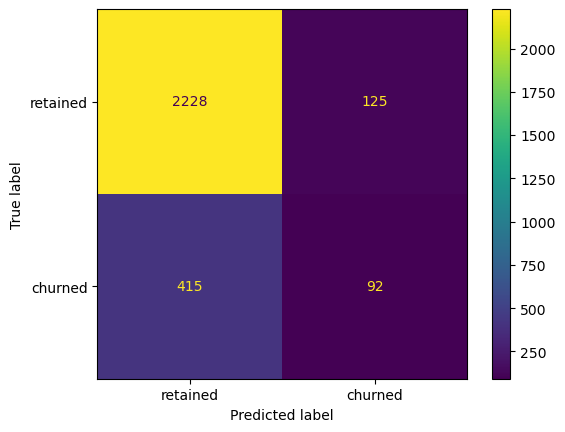

In [40]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['retained', 'churned'])
disp.plot();

**Compare the importance of various features in the model.**

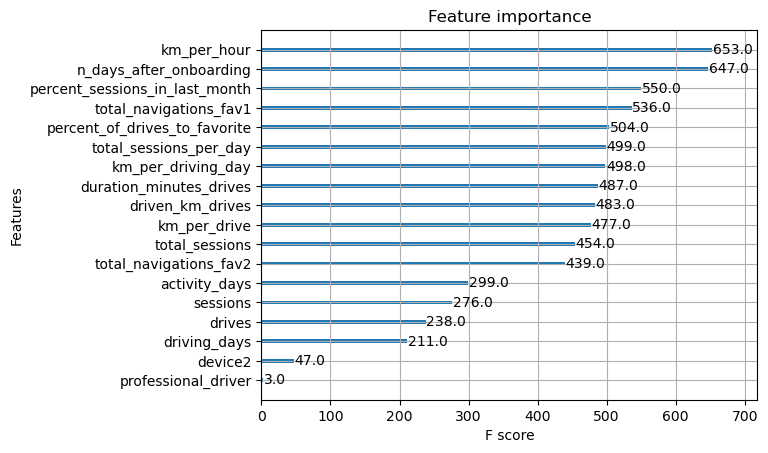

In [41]:
plot_importance(xgb_cv.best_estimator_);

**Considering the specific business problem at hand, we want to improve the Recall score, even when it compromises other scores. First plot the Precision-Recall curve for the XGBoost model to get the idea behind it.** 

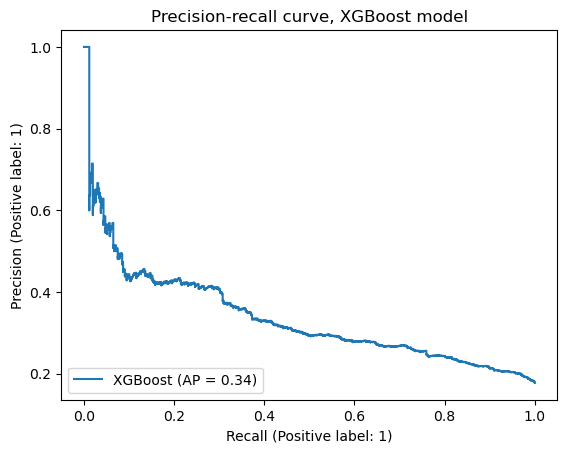

In [42]:
display = PrecisionRecallDisplay.from_estimator(xgb_cv.best_estimator_, X_test, y_test, name='XGBoost')
plt.title('Precision-recall curve, XGBoost model');

**Define a function to find the decision threshold that most closely yields a desired recall score for the given model.**

In [43]:
def threshold_finder(y_test_data, probabilities, desired_recall):

    probs = [x[1] for x in probabilities] 
    thresholds = np.arange(0, 1, 0.001)    

    scores = []
    for threshold in thresholds:
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        recall = recall_score(y_test_data, preds)
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        distance = abs(score[1] - desired_recall)
        distances.append((idx, distance))

    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    best = sorted_distances[0]
    best_idx = best[0]
    threshold, recall = scores[best_idx]

    return threshold, recall

**Find the value of decision threshold. Find the updated performance of the model using this decision threshold, and display the updated confusion matrix.**

In [44]:
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
threshold_finder(y_test, probabilities, 0.5)

(0.194, 0.4990138067061144)

In [45]:
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.194 else 0 for x in probs])
get_test_scores('XGB, threshold = 0.194', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.194",0.293163,0.499014,0.369343,0.697902


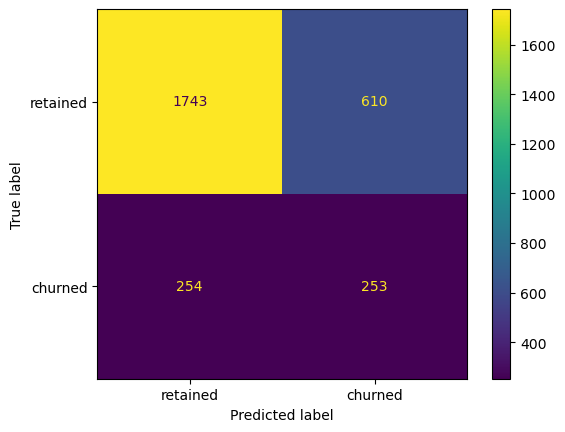

In [46]:
cm = confusion_matrix(y_test, new_preds, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot();

**Conclusion:** Since we want to reduce the user churn, we want to provide small incentives to the users which model predicts would churn. So it makes more sense to improve the Recall as far as possible so that the model predicts a larger fraction of users about to churn at the cost of erroneously predicting non-churning users. This is clear by comparing original confusion matrix with the updated one.    